In [1]:
import ciw
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.integrate import odeint
from tqdm.notebook import tqdm
import pickle

### System Dynamics Component

In [2]:
def proportional_gatekeeping(threshold):
    """
    Proportional gatekeeping function.

    Parameters
    ----------
    threshold : float in [0, 1]
        Proportion threshold for gatekeeping

    Returns
    -------
    function
        Function to calculate lambda values for each stock.
    """
    def gatekeeping_function(stocks, population, presenting_rate, t):
        """
        Gatekeeping function to calculate lambda values for each stock.
        Parameters
        ----------
        stocks : list of floats or arrays
            Stock levels at current time step t or over time
        population : float or array
            Total population at time t (scalar or array)
        presenting_rate : float in [0, 1]
            Rate of patients presenting from each stock
        Returns
        -------
        list
            list of arrays or scalars representing the lambda values for each stock.
        """
        stocks = np.array(stocks)
        lambdas = []

        for i in range(len(stocks)):
            if i == 0:
                subtracted = 0
            else:
                subtracted = sum(stocks[:i])
            stock = stocks[i]
            ratio = np.zeros_like(stock)
            positives = stock > 0
            if np.isscalar(subtracted):
                ratio[positives] = (
                    (threshold * population) - subtracted
                ) / stock
            else:
                ratio[positives] = (
                    (threshold * population[positives])
                    - subtracted[positives]
                ) / stock[positives]
            lambdas.append(presenting_rate * np.clip(ratio, 0, 1) * stock)
        return lambdas
    return gatekeeping_function

In [3]:
def fixed_gatekeeping(threshold):
    """
    Fixed gatekeeping function.

    Parameters
    ----------
    threshold : float or int
        Fixed capacity threshold for gatekeeping per time step

    Returns
    -------
    function
        Function to calculate lambda values for each stock.
    """
    def gatekeeping_function(stocks, population, presenting_rate, t):
        """
        Gatekeeping function to calculate lambda values for each stock.
        Parameters
        ----------
        stocks : list of scalars or arrays
            Stock levels at current time step t or over time
        population : float or array
            Total population at time t (scalar or array)
        presenting_rate : float in [0, 1]
            Rate of patients presenting from each stock
        Returns
        -------
        list
            list of arrays or scalars representing the lambda values for each stock.
        """
        if np.isscalar(stocks[0]):
            remaining_capacity = threshold
            lambdas = []
            for stock in stocks:
                demand = presenting_rate * stock
                allowed = min(demand, remaining_capacity)
                lambdas.append(allowed)
                remaining_capacity -= allowed
                remaining_capacity = max(remaining_capacity, 0)
            return lambdas
        else:
            stocks = [np.asarray(s) for s in stocks]
            time_steps = len(stocks[0])
            lambdas = [np.zeros(time_steps) for _ in stocks]
            remaining_capacity = np.full(time_steps, threshold, dtype=float)
            for i, stock in enumerate(stocks):
                demand = presenting_rate * stock
                allowed = np.minimum(demand, remaining_capacity)
                lambdas[i] = allowed
                remaining_capacity = np.maximum(remaining_capacity - allowed, 0)
            return lambdas
    return gatekeeping_function

In [4]:
class SD:
    """
    A class to hold the SD component.
    """

    def __init__(
        self,
        initial_population,
        unwell_proportion,
        unwell_splits,
        gatekeeping_function,
        presenting_rate,
        deterioration_rate,
        incidence_rate,
    ):
        """
        Initialised the parameters for the SD component

        Parameters
        ----------
        initial_population : a positive integer
            initial population of the system
        unwell_proportion : a positive float <= 1
            proportion of the initial population that is unwell
        unwell_splits : a tuple of three floats that sum to 1
            representing the proportions of the unwell population in each stock
        gatekeeping_function : a function
            function to calculate lambda values for each stock
        presenting_rate : a positive float <= 1
            rate at which patients present for treatment
        deterioration_rate : a positive float <= 1
            rate at which patients deteriorate
        incidence_rate : a positive float <= 1
            rate at which new patients enter the system
        """
        w = unwell_splits
        self.initial_population = initial_population
        unwell_pop = initial_population * unwell_proportion
        self.P = [
            unwell_pop * w[0], 
            unwell_pop * w[1], 
            unwell_pop * w[2]
        ]
        self.presenting_rate = presenting_rate
        self.gatekeeping_function = gatekeeping_function
        self.deterioration_rate = deterioration_rate
        self.incidence_rate = incidence_rate
        self.time = np.array([0])
        self.lambdas = None

    def differential_equations(
        self,
        y,
        time_domain,
    ):
        """
        Defines the system of differential equations that describe the
        population model.

        Parameters
        ----------
        y : a tuple of three integers
            representing the populations in each stock
        time_domain : a float
            representing the time domain for the simulation

        Returns
        -------
        tuple
            dP_onedt, dP_twodt, dP_threedt : floats
        """
        P_one, P_two, P_three = y
        N_current = P_one + P_two + P_three
        all_stocks = [P_one, P_two, P_three]

        if N_current == 0:
            return 0, 0, 0

        susceptible_population = max(self.initial_population - N_current, 0)
        lambdas = self.gatekeeping_function(
            stocks=all_stocks,
            population=N_current,
            presenting_rate=self.presenting_rate,
            t=time_domain,
        )

        dP_onedt = -lambdas[0] + self.deterioration_rate * P_two
        dP_twodt = (
            -lambdas[1]
            - (self.deterioration_rate * P_two)
            + (self.deterioration_rate * P_three)
        )
        dP_threedt = (
            -lambdas[2]
            - (self.deterioration_rate * P_three)
            + (self.incidence_rate * susceptible_population)
        )
        return dP_onedt, dP_twodt, dP_threedt

    def solve(
        self,
        t,
    ):
        """
        Solves the differential equations from the time of the previous event
        to time t.
        """
        # Solve the SD over the relevant time domain
        y = self.P
        results = odeint(
            self.differential_equations,
            y,
            t,
        )

        P1, P2, P3 = results.T
        self.P[0] = np.append(self.P[0], P1)
        self.P[1] = np.append(self.P[1], P2)
        self.P[2] = np.append(self.P[2], P3)

        # Extract the lambdas from the results
        self.lambdas = self.gatekeeping_function(
            stocks=[P1, P2, P3],
            population=P1 + P2 + P3,
            presenting_rate=self.presenting_rate,
            t=t,
        )

In [5]:
A = SD(
    initial_population=100000,
    unwell_proportion=0.1,
    unwell_splits=[0.1, 0.3, 0.6],
    gatekeeping_function=proportional_gatekeeping(threshold=0.4),
    presenting_rate=0.002 / 3,
    deterioration_rate=0.005,
    incidence_rate=0,
)
ts = np.linspace(0, 1000, 100000 + 1)
A.solve(t=ts)

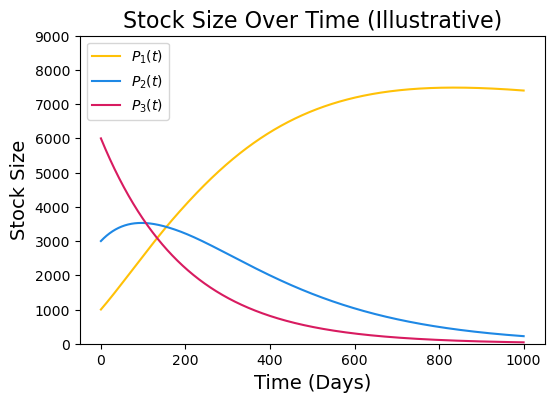

In [6]:
fig, ax = plt.subplots(1)
fig.set_size_inches(6, 4)
ax.plot(ts, A.P[0][1:], label="$P_1(t)$", color="#FFC107")
ax.plot(ts, A.P[1][1:], label="$P_2(t)$", color="#1E88E5")
ax.plot(ts, A.P[2][1:], label="$P_3(t)$", color="#D81B60")
ax.set_title("Stock Size Over Time (Illustrative)", fontsize=16)
ax.set_xlabel("Time (Days)", fontsize=14)
ax.set_ylabel("Stock Size", fontsize=14)
ax.set_ylim(0, 9000)
ax.legend(fontsize=10)
plt.savefig("stock_size.png", dpi=300, bbox_inches="tight", transparent=True)

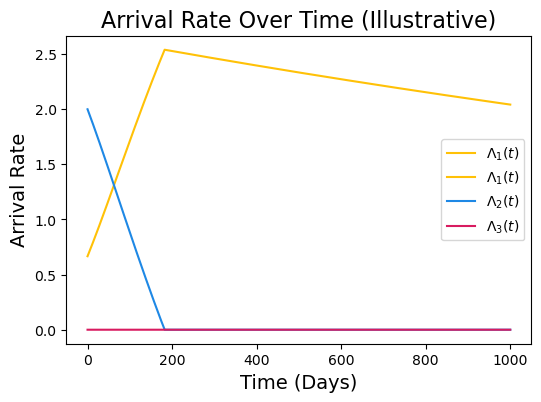

In [7]:
fig, ax = plt.subplots(1)
fig.set_size_inches(6, 4)
ax.plot(ts, A.lambdas[0], 0, label="$Λ_1(t)$", color="#FFC107")
ax.plot(ts, A.lambdas[1], label="$Λ_2(t)$", color="#1E88E5")
ax.plot(ts, A.lambdas[2], label="$Λ_3(t)$", color="#D81B60")
ax.set_title("Arrival Rate Over Time (Illustrative)", fontsize=16)
ax.set_xlabel("Time (Days)", fontsize=14)
ax.set_ylabel("Arrival Rate", fontsize=14)
ax.legend(fontsize=10)
plt.savefig("arrival_rate.png", dpi=300, bbox_inches="tight", transparent=True)

### Loading the Subgroup PDFAs

In [9]:
pdfa_one = np.load("../pdfas/example_high_pdfa.npy")
pdfa_one_alphabet = pickle.load(open("../pdfas/example_high_pdfa_alphabet.pkl", "rb"))

In [10]:
pdfa_two = np.load("../pdfas/example_medium_pdfa.npy")
pdfa_two_alphabet = pickle.load(open("../pdfas/example_medium_pdfa_alphabet.pkl", "rb"))

In [11]:
pdfa_three = np.load("../pdfas/example_low_pdfa.npy")
pdfa_three_alphabet = pickle.load(open("../pdfas/example_low_pdfa_alphabet.pkl", "rb"))

In [12]:
activity_dict = dict()
activity_dict["A"] = 2
activity_dict["B"] = 3
activity_dict["C"] = 4
activity_dict["D"] = 5
activity_dict["F"] = 6
activity_dict["G"] = 7
activity_dict["H"] = 8
activity_dict["I"] = 9
activity_dict["J"] = 10
inv_dict = {v: k for k, v in activity_dict.items()}
inv_dict[1] = ""

In [13]:
nodes = ["*", "A", "B", "C", "D", "F", "G", "H", "I", "J"]

### Discrete-Event Simulation Component

In [14]:
class HighCustomRouting(ciw.routing.NodeRouting):
    def next_node(self, ind):
        p_matrix = pdfa_one
        alphabet = pdfa_one_alphabet

        if hasattr(ind, "route_position") == False:
            ind.route_position = 1
        leaving_row = ind.route_position
        p_values = []
        next_state = []
        next_activity = []
        for letter in range(len(alphabet)):
            if p_matrix[letter, leaving_row, :].sum() > 0:
                p_values.append(p_matrix[letter, leaving_row, :].sum())
                next_state.append(np.where(p_matrix[letter, leaving_row, :] > 0)[0][0])
                next_activity.append(letter)
        final_prob = 1 - sum(p_values)
        if final_prob > 0:
            p_values.append(final_prob)
            next_state.append("tau")
            next_activity.append(-1)
        next = np.random.choice(a=next_activity, p=p_values)
        next_position = next_state[next_activity.index(next)]
        if next == -1:
            ind.route_position = -1
            return self.simulation.nodes[-1]
        else:
            next_node = activity_dict[alphabet[next]]
            ind.route_position = next_position
            return self.simulation.nodes[next_node]

In [15]:
class MediumCustomRouting(ciw.routing.NodeRouting):
    def next_node(self, ind):
        p_matrix = pdfa_two
        alphabet = pdfa_two_alphabet

        if hasattr(ind, "route_position") == False:
            ind.route_position = 1
        leaving_row = ind.route_position
        p_values = []
        next_state = []
        next_activity = []
        for letter in range(len(alphabet)):
            if p_matrix[letter, leaving_row, :].sum() > 0:
                p_values.append(p_matrix[letter, leaving_row, :].sum())
                next_state.append(np.where(p_matrix[letter, leaving_row, :] > 0)[0][0])
                next_activity.append(letter)
        final_prob = 1 - sum(p_values)
        if final_prob > 0:
            p_values.append(final_prob)
            next_state.append("tau")
            next_activity.append(-1)
        next = np.random.choice(a=next_activity, p=p_values)
        next_position = next_state[next_activity.index(next)]
        if next == -1:
            ind.route_position = -1
            return self.simulation.nodes[-1]
        else:
            next_node = activity_dict[alphabet[next]]
            ind.route_position = next_position
            return self.simulation.nodes[next_node]

In [16]:
class LowCustomRouting(ciw.routing.NodeRouting):
    def next_node(self, ind):
        p_matrix = pdfa_three
        alphabet = pdfa_three_alphabet

        if hasattr(ind, "route_position") == False:
            ind.route_position = 1
        leaving_row = ind.route_position
        p_values = []
        next_state = []
        next_activity = []
        for letter in range(len(alphabet)):
            if p_matrix[letter, leaving_row, :].sum() > 0:
                p_values.append(p_matrix[letter, leaving_row, :].sum())
                next_state.append(np.where(p_matrix[letter, leaving_row, :] > 0)[0][0])
                next_activity.append(letter)
        final_prob = 1 - sum(p_values)
        if final_prob > 0:
            p_values.append(final_prob)
            next_state.append("tau")
            next_activity.append(-1)
        next = np.random.choice(a=next_activity, p=p_values)
        next_position = next_state[next_activity.index(next)]
        if next == -1:
            return self.simulation.nodes[-1]
        else:
            next_node = activity_dict[alphabet[next]]
            ind.route_position = next_position
            return self.simulation.nodes[next_node]

In [17]:
N = ciw.create_network(
    arrival_distributions={
        "Low": [
            ciw.dists.PoissonIntervals(
                rates=list(A.lambdas[2][:-1]),
                endpoints=list(ts[1:]),
                max_sample_date=1001,
            ),
            None,
            None,
            None,
            None,
            None,
            None,
            None,
            None,
            None,
            None,
        ],
        "Medium": [
            ciw.dists.PoissonIntervals(
                rates=list(A.lambdas[1][:-1]),
                endpoints=list(ts[1:]),
                max_sample_date=1001,
            ),
            None,
            None,
            None,
            None,
            None,
            None,
            None,
            None,
            None,
            None,
        ],
        "High": [
            ciw.dists.PoissonIntervals(
                rates=list(A.lambdas[0][:-1]),
                endpoints=list(ts[1:]),
                max_sample_date=1001,
            ),
            None,
            None,
            None,
            None,
            None,
            None,
            None,
            None,
            None,
            None,
        ],
    },
    service_distributions={
        "Low": [
            ciw.dists.Deterministic(value=0),
            ciw.dists.Deterministic(value=0.1),
            ciw.dists.Deterministic(value=0.1),
            ciw.dists.Deterministic(value=2 / 7),
            ciw.dists.Deterministic(value=2 / 7),
            ciw.dists.Deterministic(value=1),
            ciw.dists.Deterministic(value=2 / 5),
            ciw.dists.Deterministic(value=2 / 7),
            ciw.dists.Deterministic(value=2 / 7),
            ciw.dists.Deterministic(value=5 / 16),
            ciw.dists.Deterministic(value=5 / 16),
        ],
        "Medium": [
            ciw.dists.Deterministic(value=0),
            ciw.dists.Deterministic(value=0.1),
            ciw.dists.Deterministic(value=0.1),
            ciw.dists.Deterministic(value=2 / 7),
            ciw.dists.Deterministic(value=2 / 7),
            ciw.dists.Deterministic(value=1),
            ciw.dists.Deterministic(value=2 / 5),
            ciw.dists.Deterministic(value=2 / 7),
            ciw.dists.Deterministic(value=2 / 7),
            ciw.dists.Deterministic(value=5 / 16),
            ciw.dists.Deterministic(value=5 / 16),
        ],
        "High": [
            ciw.dists.Deterministic(value=0),
            ciw.dists.Deterministic(value=0.1),
            ciw.dists.Deterministic(value=0.1),
            ciw.dists.Deterministic(value=2 / 7),
            ciw.dists.Deterministic(value=2 / 7),
            ciw.dists.Deterministic(value=1),
            ciw.dists.Deterministic(value=2 / 5),
            ciw.dists.Deterministic(value=2 / 7),
            ciw.dists.Deterministic(value=2 / 7),
            ciw.dists.Deterministic(value=5 / 16),
            ciw.dists.Deterministic(value=5 / 16),
        ],
    },
    number_of_servers=[float("inf"), 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
    routing={
        "Low": ciw.routing.NetworkRouting(
            routers=[
                LowCustomRouting(),
                LowCustomRouting(),
                LowCustomRouting(),
                LowCustomRouting(),
                LowCustomRouting(),
                LowCustomRouting(),
                LowCustomRouting(),
                LowCustomRouting(),
                LowCustomRouting(),
                LowCustomRouting(),
                LowCustomRouting(),
            ]
        ),
        "Medium": ciw.routing.NetworkRouting(
            routers=[
                MediumCustomRouting(),
                MediumCustomRouting(),
                MediumCustomRouting(),
                MediumCustomRouting(),
                MediumCustomRouting(),
                MediumCustomRouting(),
                MediumCustomRouting(),
                MediumCustomRouting(),
                MediumCustomRouting(),
                MediumCustomRouting(),
                MediumCustomRouting(),
            ]
        ),
        "High": ciw.routing.NetworkRouting(
            routers=[
                HighCustomRouting(),
                HighCustomRouting(),
                HighCustomRouting(),
                HighCustomRouting(),
                HighCustomRouting(),
                HighCustomRouting(),
                HighCustomRouting(),
                HighCustomRouting(),
                HighCustomRouting(),
                HighCustomRouting(),
                HighCustomRouting(),
            ]
        ),
    },
)

In [18]:
Q = ciw.Simulation(N)
Q.simulate_until_max_time(1000)
r = pd.DataFrame(Q.get_all_records())
r

,id_number,customer_class,original_customer_class,node,arrival_date,waiting_time,service_start_date,service_time,service_end_date,time_blocked,exit_date,destination,queue_size_at_arrival,queue_size_at_departure,server_id,record_type
0,2279,High,High,1,999.953925,0.000000,999.953925,0.000000,999.953925,0.0,999.953925,2,0,0,False,service
1,2275,High,High,1,996.538375,0.000000,996.538375,0.000000,996.538375,0.0,996.538375,3,0,0,False,service
2,2275,High,High,3,996.538375,0.000000,996.538375,0.100000,996.638375,0.0,996.638375,5,0,0,1,service
3,2275,High,High,5,996.638375,0.054096,996.692470,0.285714,996.978185,0.0,996.978185,6,1,0,1,service
4,2275,High,High,6,996.978185,0.783277,997.761462,1.000000,998.761462,0.0,998.761462,6,1,1,1,service
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12522,2269,High,High,2,993.539425,0.055429,993.594854,0.100000,993.694854,0.0,993.694854,5,1,0,1,service
12523,2269,High,High,5,993.694854,0.185714,993.880569,0.285714,994.166283,0.0,994.166283,10,1,1,1,service
12524,2269,High,High,10,994.166283,1.657679,995.823962,0.312500,996.136462,0.0,996.136462,6,6,8,1,service
12525,2269,High,High,6,996.136462,0.625000,996.761462,1.000000,997.761462,0.0,997.761462,6,1,1,1,service
